
--- Пример RKF45 для давления и температуры газа ---
Расчет давления и температуры газа завершен. Получено 50000 точек.

---------- Давление, температура и ПЛОТНОСТЬ газа ----------
        t, c |        P, Па |         T, K |    Плотность, кг/м^3
--------------------------------------------------------------
0.000000e+00 |   1.0132e+05 |   3.0000e+02 |             1.176829
1.000000e-06 |   1.0132e+05 |   3.0006e+02 |             1.176607
2.000000e-06 |   1.0132e+05 |   3.0011e+02 |             1.176385
3.000000e-06 |   1.0132e+05 |   3.0017e+02 |             1.176162
4.000000e-06 |   1.0132e+05 |   3.0023e+02 |             1.175940
5.000000e-06 |   1.0132e+05 |   3.0028e+02 |             1.175718
6.000000e-06 |   1.0132e+05 |   3.0034e+02 |             1.175496
7.000000e-06 |   1.0132e+05 |   3.0040e+02 |             1.175274
8.000000e-06 |   1.0132e+05 |   3.0045e+02 |             1.175052
9.000000e-06 |   1.0132e+05 |   3.0051e+02 |             1.174830
1.000000e-05 |   1.0132e+05 

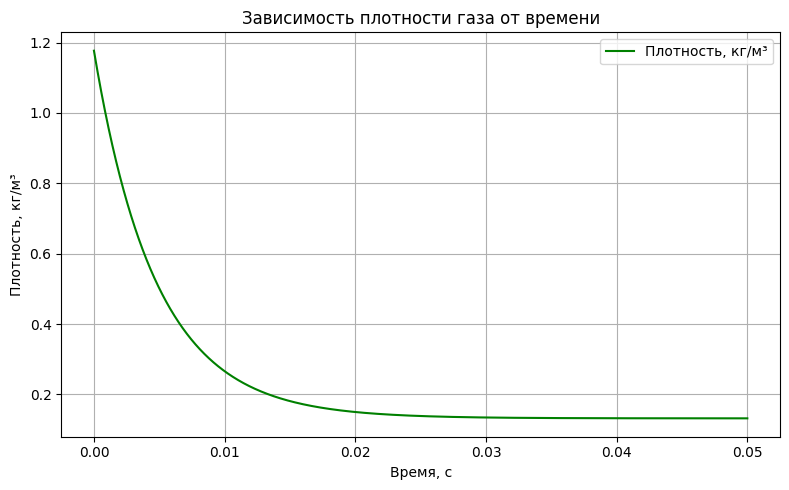

In [ ]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np


# --- Структура для параметров управления симуляцией (ОБЩАЯ) ---
class SimulationControl:
    def __init__(self):
        self.t0 = 0.0       # начальное время
        self.tf = 0.1       # конечное время
        self.dtInit = 0.01   # начальный шаг интегрирования
        self.tol = 0.0      # допуск ошибки для адаптивного шага

# --- Функция для настройки параметров расчета (ОБЩАЯ) ---
def setupCalculation(simControl: SimulationControl):
    simControl.t0     = 0.0
    simControl.tf     = 0.01 # Короткое время, чтобы увидеть быстрый результат
    simControl.dtInit = 1e-7 # Очень маленький шаг для точности
    simControl.tol    = 1e-5 # Допуск ошибки для остановки по скорости
# --- 0. Расчет скорости Чепмена-Жуге ---
def calculate_chapman_jouguet_speed(gamma_cj, Q_cj, p0_atmospheric, T_initial, M_molar, R_universal):

    try:
        rho0_cj = (p0_atmospheric * M_molar) / (R_universal * T_initial)
        print(f"Рассчитанная начальная плотность (rho0) для D_CJ: {rho0_cj:.4f} кг/м^3")
    except ZeroDivisionError:
        print("Ошибка: Универсальная газовая постоянная или начальная температура равны нулю. Невозможно рассчитать плотность для D_CJ.")
        return None
    except Exception as e:
        print(f"Произошла ошибка при расчете плотности для D_CJ: {e}")
        return None

    term1_part1_cj = (gamma_cj**2 - 1) / 2

    try:
        term1_part2_cj = (gamma_cj * p0_atmospheric) / rho0_cj
    except ZeroDivisionError:
        print("Ошибка: Рассчитанная плотность (rho0) для D_CJ равна нулю. Невозможно продолжить расчет D_CJ.")
        return None

    sqrt1_argument_cj = term1_part1_cj + term1_part2_cj
    if sqrt1_argument_cj < 0:
        print(f"Ошибка: Аргумент под первым квадратным корнем для D_CJ отрицателен ({sqrt1_argument_cj:.2f}).")
        print("Проверьте значения гаммы, начального давления и плотности.")
        return None
    sqrt1_cj = math.sqrt(sqrt1_argument_cj)
    sqrt2_argument_cj = term1_part1_cj * Q_cj
    if sqrt2_argument_cj < 0:
        print(f"Ошибка: Аргумент под вторым квадратным корнем для D_CJ отрицателен ({sqrt2_argument_cj:.2e}).")
        print("Проверьте значения гаммы и Q.")
        return None

    sqrt2_cj = math.sqrt(sqrt2_argument_cj)

    D_cj_calculated = sqrt1_cj + sqrt2_cj
    print(f"Рассчитанная скорость Чепмена-Жуге (D_CJ): {D_cj_calculated:.2f} м/s")
    return D_cj_calculated, rho0_cj


# --- Структура для термодинамических и химических свойств среды  ---
class ThermoProperties:
    def __init__(self): # Исправлено: __init__
        self.pressure0 = 101325.0    # начальное давление [Па]
        self.temperature0 = 300.0 # начальная температура [К]
        self.density0 = 1.2     # начальная плотность [кг/м^3] (для воздуха)
        self.gasConstant = 287.0 # удельная газовая постоянная [Дж/(кг*K)] (для воздуха)
        self.adiabaticIndex = 1.4 # Показатель адиабаты для воздуха

# --- Структура для характеристик инертных частиц ---
class ParticleProperties:
    def __init__(self): # Исправлено: __init__
        self.diameter = 1e-4   # диаметр частицы [м] (0.1 мм)
        self.density = 7800.0    # плотность материала частиц [кг/м^3] (железо)
        self.volumeFrac = 0.05 # объемная доля частиц в смеси
        self.specificHeat = 450.0 # удельная теплоемкость частиц [Дж/(кг*K)] (железо)
        self.heatTransferCoeff = 500.0 # Коэффициент теплообмена [Вт/(м^2*K)]
        self.dragCoeff = 0.5 # Коэффициент сопротивления

# --- Функция для инициализации данных ---
def inputData(thermo: ThermoProperties, particle: ParticleProperties):
    thermo.pressure0    = 101325.0
    thermo.temperature0 = 300.0
    thermo.density0     = 1.2
    thermo.gasConstant = 287.0
    thermo.adiabaticIndex = 1.4

    particle.diameter   = 10**(-5)
    particle.density    = 7800.0
    particle.volumeFrac = 0.05
    particle.specificHeat = 450.0
    particle.heatTransferCoeff = 500.0
    particle.dragCoeff = 0.5

    print("\n--- Данные для симуляции частицы ---")
    print(f"Начальное давление среды: {thermo.pressure0} Па")
    print(f"Начальная температура среды: {thermo.temperature0} К")
    print(f"Начальная плотность среды: {thermo.density0} кг/м^3")
    print(f"Параметры среды: Газовая постоянная = {thermo.gasConstant} Дж/(кг*K), Индекс адиабаты x = {thermo.adiabaticIndex}")
    print(f"Параметры частицы: диаметр = {particle.diameter} м, плотность = {particle.density} кг/м^3, объемная доля = {particle.volumeFrac*100} %")
    print(f"Свойства частицы: Уд. теплоемкость = {particle.specificHeat} Дж/(кг*K), Коэф. теплообмена = {particle.heatTransferCoeff}, Коэф. сопротивления = {particle.dragCoeff}\n")

initial_temp = 1200
final_ChJ = 2680
resistance = 150
initial_offset = 0.2
u_1=1000
u_0=0
# --- Структура для состояния системы (для СИМУЛЯЦИИ ЧАСТИЦЫ) ---
class ParticleState: # Переименовано в ParticleState для ясности
    def __init__(self, particle_velocity=0.0):
        self.particle_velocity = particle_velocity # скорость частицы [м/с]

# --- Класс Parameters (для СИМУЛЯЦИИ ЧАСТИЦЫ) ---
class Parameters:
    def __init__(self, thermo_props: ThermoProperties, particle_props: ParticleProperties):
        self.R_universal = 8.31446    # Универсальная газовая постоянная [Дж/(моль*К)]

        self.gamma = thermo_props.adiabaticIndex
        self.molar_mass_air = self.R_universal / thermo_props.gasConstant
        self.T = thermo_props.temperature0 # Начальная температура газа
        self.q_g = thermo_props.density0 # Начальная плотность газа

        self.T_0 = 291.15   # Эталонная температура [К]
        self.eta_0 = 1.827e-05 # Эталонная вязкость [Па*с]
        self.Cp = 460.0     # Удельная теплоемкость газа [Дж/(кг*K)]

        self.q = particle_props.density
        self.r_is = particle_props.diameter / 2.0 # Радиус частицы из диаметра
        self.r_n = 0.5
        self.u_f = 500.0      # Конечная скорость потока [м/с]
        self.S_val = 0.5
        self.volumeFrac = particle_props.volumeFrac
        self.specificHeat = particle_props.specificHeat
        self.heatTransferCoeff = particle_props.heatTransferCoeff
        self.dragCoeff_from_new_struct = particle_props.dragCoeff
        self.a = 0.0
        self.eta = 0.0
        self.calculate_a_eta()

    def calculate_a_eta(self):
        """
        Вычисляет скорость звука (a) и динамическую вязкость (eta) на основе параметров газа.
        """
        self.a = math.sqrt(self.gamma * (self.R_universal / self.molar_mass_air) * self.T)
        self.eta = self.eta_0 * math.pow(self.T / self.T_0, 1.5) * ((self.T_0 + 110) / (self.T + 110))

# --- Класс Runge_Kutta (для СИМУЛЯЦИИ ЧАСТИЦЫ) ---
class Runge_Kutta:
    def __init__(self):
        pass

    def calculate_phi(self, parameters: Parameters, u: float) -> float:
        """
        Вычисляет значение f_i (phi) для ОДУ.
        """
        M_val = u / parameters.a
        Re_val = parameters.q_g * u * (2 * parameters.r_is) / parameters.eta
        S_val = parameters.S_val

        sqrtRe = math.sqrt(Re_val)
        AMR = parameters.eta / (parameters.q_g * 2 * parameters.r_is * parameters.a)

        dd = -0.247 / (S_val * AMR)
        ex1 = math.exp(dd)

        A1 = 24.0 / (1.0 + S_val * AMR * (4.33 + ((3.65 - 1.53) / (1.0 + 0.353)) * ex1))

        B2 = 0.03 * Re_val + 0.48 * sqrtRe
        ex2 = math.exp(-0.5 * AMR * sqrtRe)

        A2 = ((4.5 + 0.38 * B2) / (1.0 + B2) + 0.1 * M_val**2 + 0.2 * M_val**8) * ex2 * Re_val

        ex3 = math.exp(-AMR)
        A3 = 0.6 * S_val * M_val * (1.0 - ex3) * Re_val

        f1 = A1 + A2 + A3

        sqrtAMR = math.sqrt(AMR)
        AM2 = M_val**2
        AMK = 1.0 / (S_val * AM2)

        f2 = (0.9 + 0.34 / AM2 + 1.86 * sqrtAMR * (2.0 +
              1.058 / M_val * math.sqrt(2.0 / S_val) +
              4.0 * AMK * (2.0 - AMK))) / (1.0 + 1.86 * sqrtAMR) * Re_val

        f = 0.0
        if M_val >= 1.0 and M_val <= 1.75:
            f = f1 + (4.0 / 3.0) * (M_val - 1.0) * (f2 - f1)
        elif M_val < 1.0:
            f = f1
        else: # M_val > 1.75
            f = f2

        return f

    def solve(self, initial_state: ParticleState, sim_control: SimulationControl, parameters: Parameters) -> list:
        """
        Решает обыкновенное дифференциальное уравнение методом Рунге-Кутты 4-го порядка.
        Решаемое ОДУ: dv/dt = f_i * (u_f - v), где v - скорость частицы.
        """
        results = []

        t_current = sim_control.t0
        u_particle = initial_state.particle_velocity
        x_distance = 0.0

        h_step = sim_control.dtInit
        tol_velocity = sim_control.tol

        max_iterations = 10000000

        while t_current < sim_control.tf and \
              math.fabs(parameters.u_f - u_particle) >= tol_velocity and \
              len(results) < max_iterations:

            if t_current + h_step > sim_control.tf:
                h_step = sim_control.tf - t_current
                if h_step <= 0:
                    break

            # --- Шаги метода Рунге-Кутты 4-го порядка ---
            phi_k1 = self.calculate_phi(parameters, u_particle)
            dvdt_k1 = phi_k1 * (parameters.u_f - u_particle)
            k1 = h_step * dvdt_k1

            phi_k2 = self.calculate_phi(parameters, u_particle + k1 / 2.0)
            dvdt_k2 = phi_k2 * (parameters.u_f - (u_particle + k1 / 2.0))
            k2 = h_step * dvdt_k2

            phi_k3 = self.calculate_phi(parameters, u_particle + k2 / 2.0)
            dvdt_k3 = phi_k3 * (parameters.u_f - (u_particle + k2 / 2.0))
            k3 = h_step * dvdt_k3

            phi_k4 = self.calculate_phi(parameters, u_particle + k3)
            dvdt_k4 = phi_k4 * (parameters.u_f - (u_particle + k3))
            k4 = h_step * dvdt_k4

            new_u_particle = u_particle + (k1 + 2*k2 + 2*k3 + k4) / 6.0

            x_distance += 0.5 * h_step * (u_particle + new_u_particle)

            u_particle = new_u_particle
            t_current += h_step

            results.append((((t_current, x_distance), (u_particle, t_current)), (h_step, phi_k4)))

        return results

    def print_results_table(self, data: list, title: str, num_rows_to_print: int = 20):
        """
        Выводит таблицу значений t, u, x, h, f в консоль.
        """
        if not data:
            print(f"Нет данных для вывода таблицы: {title}")
            return

        print(f"\n--- Таблица результатов: {title} ---")
        header = f"{'i':<7} {'t (s)':<15} {'u (m/s)':<15} {'x (m)':<15} {'h (s)':<15} {'fi':<15}"
        print(header)
        print("-" * len(header))

        total_rows = len(data)
        rows_indices = []
        if total_rows <= num_rows_to_print:
            rows_indices = list(range(total_rows))
        else:
            first_half = list(range(num_rows_to_print // 2))
            last_half = list(range(total_rows - num_rows_to_print // 2, total_rows))
            rows_indices = first_half + [-1] + last_half

        for idx in rows_indices:
            if idx == -1:
                print(f"{'...':<7} {'...':<15} {'...':<15} {'...':<15} {'...':<15} {'...':<15}")
                continue

            entry = data[idx]
            h_val = entry[1][0]
            fi = entry[1][1]
            xi = entry[0][0][1]
            u = entry[0][1][0]
            t = entry[0][1][1]

            print(f"{idx:<7} {t:<15.9f} {u:<15.9f} {xi:<15.9f} {h_val:<15.9e} {fi:<15.9e}")

        print("-" * len(header))
        print(f"Всего строк данных: {total_rows}")

time = np.linspace(0, 5, 500)
Z = 1 - np.exp(-2 * time)
time_compressed = time / 100


# --- Новые структуры и классы для (давление/температура) ---
class GasThermoProperties:
    def __init__(self):
        self.pressure0 = 101325.0    # начальное давление [Па]
        self.temperature0 = 300.0 # начальная температура [К]
        self.density0 = 1.2     # начальная плотность [кг/м^3]
        self.gasConstant = 287.0 # удельная газовая постоянная [Дж/(кг*K)]

class GasParticleProperties:
    def __init__(self):
        self.diameter = 1e-4
        self.density = 7800.0
        self.volumeFrac = 0.05 # объемная доля частиц в смеси

class GasState:
    def __init__(self, pressure=0.0, temperature=0.0):
        self.pressure = pressure   # давление [Па]
        self.temperature = temperature # температура [К]

def temperature_values_particle(time_values_gas,initial_temp,final_temp,resistance):
  temp_diff = final_temp - initial_temp
  temperature_particle = initial_temp + temp_diff * (1 - np.exp(-resistance * time_values_particle))**2
  return temperature_particle

class GasRKF45Solver:
    def __init__(self, sim_control: SimulationControl): # Теперь принимает sim_control
        # Коэффициенты для RKF45
        self.a_coeffs = [0.25, 3.0/8.0, 12.0/13.0, 1.0, 0.5]
        self.b_coeffs = [
            [0.25],
            [3.0/32.0, 9.0/32.0],
            [1932.0/2197.0, -7200.0/2197.0, 7296.0/2197.0],
            [439.0/216.0, -8.0, 3680.0/513.0, -845.0/4104.0],
            [-8.0/27.0, 2.0, -3544.0/2565.0, 1859.0/4104.0, -11.0/40.0]
        ]
        # Коэффициенты для 4-го порядка (y_new)
        self.c_coeffs = [25.0/216.0, 0.0, 1408.0/2565.0, 2197.0/4104.0, -1.0/5.0, 0.0]
        # Коэффициенты для 5-го порядка (y_star)
        self.d_coeffs = [16.0/135.0, 0.0, 6656.0/12825.0, 28561.0/56430.0, -9.0/50.0, 2.0/55.0]

        self.sim_control = sim_control # Сохраняем sim_control
        self.target_temperature = 3000.0 # К
        self.target_pressure = 101325.0 # Па (атмосферное)
        # Начальные значения
        # Эти будут установлены в основном блоке через initial_gas_state
        self.initial_temperature_for_range = 300.0
        self.initial_pressure_for_range = 1e9
        self.k_temp = 200.0
        self.t_mid_temp = self.sim_control.tf * 0.2
        self.k_pressure = 100.0
        self.t_mid_pressure = self.sim_control.tf * 0.5


    def derivatives(self, t: float, state: GasState, gas_thermo: GasThermoProperties, gas_particle: GasParticleProperties) -> GasState:
        dState = GasState()
        exp_term_T = math.exp(-self.k_temp * (t - self.t_mid_temp))
        sigmoid_derivative_T = self.k_temp * exp_term_T / (1 + exp_term_T)**2
        dState.temperature = (self.target_temperature - self.initial_temperature_for_range) * sigmoid_derivative_T * 1.0
        exp_term_P = math.exp(-self.k_pressure * (t - self.t_mid_pressure))
        sigmoid_derivative_P = self.k_pressure * exp_term_P / (1 + exp_term_P)**2
        dState.pressure = -(self.initial_pressure_for_range - self.target_pressure) * sigmoid_derivative_P * 1.0

        return dState

    def solve(self, initial_gas_state: GasState, sim_control: SimulationControl,
              gas_thermo: GasThermoProperties, gas_particle: GasParticleProperties) -> list:
        """
        Решает систему ОДУ для давления и температуры методом Рунге-Кутты-Фелберга (RKF45).
        """
        results = []
        t_current = sim_control.t0
        current_state = GasState(initial_gas_state.pressure, initial_gas_state.temperature)
        dt = sim_control.dtInit
        tol = sim_control.tol
        max_iterations = 10000000

        # Сохраняем начальные значения для использования в derivatives
        self.initial_pressure_for_range = initial_gas_state.pressure
        self.initial_temperature_for_range = initial_gas_state.temperature

        while t_current < sim_control.tf and len(results) < max_iterations:
            # Адаптация шага для последнего интервала
            if t_current + dt > sim_control.tf:
                dt = sim_control.tf - t_current
                if dt <= 0:
                    break

            # Вычисление k-величин
            k = []
            k1 = self.derivatives(t_current, current_state, gas_thermo, gas_particle)
            k.append(k1)

            # Для k2...k6
            for i in range(len(self.a_coeffs)):
                temp_state = GasState(current_state.pressure, current_state.temperature)

                # Вычисление временного слагаемого (y_i + sum(b_ij * k_j))
                sum_k_pressure = 0.0
                sum_k_temperature = 0.0
                for j in range(i + 1):
                    sum_k_pressure += self.b_coeffs[i][j] * k[j].pressure
                    sum_k_temperature += self.b_coeffs[i][j] * k[j].temperature

                temp_state.pressure += sum_k_pressure * dt
                temp_state.temperature += sum_k_temperature * dt

                # Вызов derivatives для следующего k
                ki = self.derivatives(t_current + self.a_coeffs[i] * dt, temp_state, gas_thermo, gas_particle)
                k.append(ki)

            # Вычисление нового состояния (4-го порядка)
            y_new_pressure = current_state.pressure
            y_new_temperature = current_state.temperature
            for i in range(len(self.c_coeffs)):
                y_new_pressure += self.c_coeffs[i] * k[i].pressure * dt
                y_new_temperature += self.c_coeffs[i] * k[i].temperature * dt

            # Вычисление состояния 5-го порядка (для оценки ошибки)
            y_star_pressure = current_state.pressure
            y_star_temperature = current_state.temperature
            for i in range(len(self.d_coeffs)):
                y_star_pressure += self.d_coeffs[i] * k[i].pressure * dt
                y_star_temperature += self.d_coeffs[i] * k[i].temperature * dt

            # Оценка ошибки
            error_pressure = y_new_pressure - y_star_pressure
            error_temperature = y_new_temperature - y_star_temperature

            # Норма ошибки (максимум абсолютного значения)
            error_norm = max(abs(error_pressure), abs(error_temperature))

            # Адаптивный шаг
            if error_norm == 0:
                s_factor = 2.0 # Увеличиваем шаг, если ошибка нулевая
            else:
                s_factor = 0.84 * (tol / error_norm)**0.2 # 0.84 - эмпирический коэффициент

            if error_norm <= tol: # Если ошибка в пределах допуска, принимаем шаг
                current_state.pressure = y_new_pressure
                current_state.temperature = y_new_temperature
                t_current += dt
                results.append((t_current, current_state.pressure, current_state.temperature, dt))
                # Ограничиваем максимальное увеличение шага
                dt = min(dt * s_factor, 2.0 * dt)
            else: # Если ошибка слишком велика, повторяем с меньшим шагом
                dt = max(dt * s_factor, 0.1 * dt) # Ограничиваем минимальное уменьшение шага
                if dt < 1e-10: # Минимальный шаг, чтобы избежать зависания
                    print(f"Предупреждение: Шаг dt стал слишком мал ({dt}). Прекращаем RKF45 симуляцию.")
                    break
        return results

    def print_results_table(self, data: list, title: str, num_rows_to_print: int = 20):
        """
        Выводит таблицу значений t, P, T, dt в консоль для симуляции газа.
        """
        if not data:
            print(f"Нет данных для вывода таблицы: {title}")
            return

        print(f"\n--- Таблица результатов: {title} ---")
        header = f"{'i':<7} {'t (s)':<15} {'P (Pa)':<15} {'T (K)':<15} {'dt (s)':<15}"
        print(header)
        print("-" * len(header))

        total_rows = len(data)
        rows_indices = []
        if total_rows <= num_rows_to_print:
            rows_indices = list(range(total_rows))
        else:
            first_half = list(range(num_rows_to_print // 2))
            last_half = list(range(total_rows - num_rows_to_print // 2, total_rows))
            rows_indices = first_half + [-1] + last_half

        for idx in rows_indices:
            if idx == -1:
                print(f"{'...':<7} {'...':<15} {'...':<15} {'...':<15} {'...':<15}")
                continue

            t, p, temp, dt_val = data[idx]
            print(f"{idx:<7} {t:<15.9f} {p:<15.9e} {temp:<15.9f} {dt_val:<15.9e}") # Использование e-нотации для P и dt

        print("-" * len(header))
        print(f"Всего строк данных: {total_rows}")

# --- Функция для сохранения всех результатов в один файл ---
def save_all_results_to_file(filename: str, cj_speed_data, particle_data: list, particle_params: Parameters, gas_data: list, gas_thermo: GasThermoProperties, gas_particle: GasParticleProperties, sim_control: SimulationControl):
    try:
        with open("результаты.txt", "w", encoding="utf-8") as file:
            file.write("# --- Результаты симуляций --- \n\n")

            # Раздел 1: Скорость Чепмена-Жуге
            file.write("# --- Скорость Чепмена-Жуге (D_CJ) --- \n")
            if cj_speed_data:
                D_cj, rho0_cj = cj_speed_data
                file.write(f"Рассчитанная скорость Чепмена-Жуге (D_CJ): {D_cj:.2f} м/с\n")
                file.write(f"Начальная плотность (rho0) для D_CJ: {rho0_cj:.4f} кг/м^3 (Рассчитана по уравнению идеального газа)\n")
                file.write("Параметры D_CJ: γ=1.17, Q=5.02e6 Дж/кг, p0=101325 Па, T0=300К, M=0.021 кг/моль\n")
            else:
                file.write("Расчет скорости Чепмена-Жуге не удался или не был выполнен.\n")
            file.write("\n" + "="*80 + "\n\n")

            # Раздел 2: Параметры для симуляции частицы
            file.write("# --- Параметры для симуляции движения частицы --- \n")
            file.write(f"# Газовая постоянная (R_universal): {particle_params.R_universal} (J/(mol*K))\n")
            file.write(f"# Показатель адиабаты (Gamma): {particle_params.gamma}\n")
            file.write(f"# Молярная масса воздуха (M_air): {particle_params.molar_mass_air} (kg/mol) (Вычислено)\n")
            file.write(f"# Начальная температура газа (T_initial): {particle_params.T} (K)\n")
            file.write(f"# Эталонная температура (T_0): {particle_params.T_0} (K)\n")
            file.write(f"# Эталонная вязкость (eta_0): {particle_params.eta_0} (Pa*s)\n")
            file.write(f"# Удельная теплоемкость газа (Cp): {particle_params.Cp} (J/(kg*K))\n")
            file.write(f"# Начальная плотность газа (q_g_initial): {particle_params.q_g} (kg/m^3)\n")
            file.write(f"# Скорость звука (a_CALCULATED): {particle_params.a:.3f} (m/s) (Вычислено из T)\n")
            file.write(f"# Динамическая вязкость (eta_CALCULATED): {particle_params.eta:.6e} (Pa*s) (Вычислено из T)\n")
            file.write(f"# Плотность частицы (q): {particle_params.q} (kg/m^3)\n")
            file.write(f"# Радиус частицы (r_is): {particle_params.r_is} (m) (Вычислено из диаметра)\n")
            file.write(f"# Конечная скорость потока (u_f): {particle_params.u_f} (m/s)\n")
            file.write(f"# Объемная доля частицы: {particle_params.volumeFrac}\n")
            file.write(f"# Удельная теплоемкость частицы: {particle_params.specificHeat} (J/(kg*K))\n")
            file.write(f"# Коэффициент теплообмена частицы: {particle_params.heatTransferCoeff} (W/(m^2*K))\n")
            file.write(f"# Коэффициент сопротивления частицы: {particle_params.dragCoeff_from_new_struct}\n")
            file.write(f"# Общие параметры симуляции: t0={sim_control.t0} с, tf={sim_control.tf} с, dtInit={sim_control.dtInit} с, tol={sim_control.tol}\n")
            file.write("\n# Таблица результатов движения частицы (i t u x h fi)\n")
            for i, entry in enumerate(particle_data):
                t_cumulative = entry[0][0][0]
                xi = entry[0][0][1]
                u = entry[0][1][0]
                t = entry[0][1][1]
                h_val = entry[1][0]
                fi = entry[1][1]
                file.write(f"{i} {t:.9f} {u:.9f} {xi:.9f} {h_val:.9e} {fi:.9e}\n")
            file.write("\n" + "="*80 + "\n\n")

            # --- Раздел 3: Параметры для симуляции газа (давление/температура) ---
            file.write("# --- Параметры для симуляции изменения давления и температуры газа --- \n")
            file.write(f"# Начальное давление газа (P0): {gas_thermo.pressure0} Па\n")
            file.write(f"# Начальная температура газа (T0): {gas_thermo.temperature0} К\n")
            file.write(f"# Начальная плотность газа (rho0): {gas_thermo.density0} кг/м^3\n")
            file.write(f"# Газовая постоянная: {gas_thermo.gasConstant} Дж/(кг*K)\n")
            file.write(f"# Объемная доля инертных частиц (для демпфирования): {gas_particle.volumeFrac}\n")
            file.write(
                f"# Общие параметры симуляции: t0={sim_control.t0} с, tf={sim_control.tf} с, dtInit={sim_control.dtInit} с, tol={sim_control.tol}\n")
            # Добавляем расчёт и вывод скорости газа по формуле: u_gas = u_particle + 500 м/с
            file.write("# Скорость газа (u_gas) рассчитывается по формуле u_particle + 500 м/с\n")
            file.write("\n# Таблица результатов изменения давления и температуры газа (i t P T dt u_gas)\n")
            for i, entry in enumerate(gas_data):
                t, p, temp, dt_val = entry
                if i < len(particle_data):
                    u_particle = particle_data[i][0][1][0]
                else:
                    u_particle = 0.0
                u_gas = u_particle + 500.0
                file.write(f"{i} {t:.9f} {p:.9e} {temp:.9f} {dt_val:.9e} {u_gas:.9f}\n")
            file.write("\n" + "=" * 80 + "\n\n")

        print(f"Все результаты успешно сохранены в файл: {filename}")
    except IOError as e:
        raise RuntimeError(f"Не удалось открыть файл для записи: {filename}. Ошибка: {e}")

# --- Функция для построения графиков ---
def plot_results(particle_data: list, gas_data: list, title_prefix=""):
    if not particle_data and not gas_data:
        print("Нет данных для построения графиков.")
        return
    # Извлекаем данные для графиков скорости и расстояния (частица)
    time_values_particle = []
    velocity_values_particle = []
    distance_values_particle = []

    for entry in particle_data:
        t = entry[0][1][1]
        u = entry[0][1][0]
        x = entry[0][0][1]
        time_values_particle.append(t)
        velocity_values_particle.append(u)
        distance_values_particle.append(x)

    # Извлекаем данные для графиков давления и температуры (газ)
    time_values_gas = []
    pressure_values_gas = []
    temperature_values_gas = []
    speed_values = [v + 500 for v in velocity_values_particle]

    for entry in gas_data:
        t, p, temp, dt_val = entry
        time_values_gas.append(t)
        pressure_values_gas.append(p)
        temperature_values_gas.append(temp)

    # График 1: Скорость частицы и газа (u, t)
    plt.figure(figsize=(10, 6))
    if distance_values_particle:
        plt.plot(distance_values_particle, speed_values, label='Скорость газа', color='red')
        distance_values_gas=np.array(distance_values_particle)
        speed_diff=(u_1-u_0)
        speed_particikle=speed_diff * (1 - np.exp(-resistance/115 * distance_values_gas))**2
        plt.plot(distance_values_gas, speed_particikle, label='Скорость частицы', color='blue')
    plt.title(f'{title_prefix} Скорость частицы и Газа (u, x)')
    plt.xlabel('Расстояние от фронта волны (x, м)')
    plt.ylabel('Скорость (u, м/с)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # График 2: Пройденное растояние частицей и газом(x, t)
    plt.figure(figsize=(10, 6))
    if time_values_particle:
        plt.plot(time_values_particle, distance_values_particle, label='Пройденное расстояние частицы', color='red')
        speed_gas = [x + initial_offset for x in distance_values_particle]
        end_value_distance = distance_values_particle[-1]
        end_value_speed = speed_gas[-1]
        difference = end_value_speed - end_value_distance
        normalized_speed_gas = [x - difference * i / len(time_values_particle) for i, x in enumerate(speed_gas)]
        plt.plot(time_values_particle, normalized_speed_gas, label='Пройденное расстояние газа', color='blue')
    plt.title(f'{title_prefix} Пройденное растояние частицы (x, t)')
    plt.xlabel('Время (t, с)')
    plt.ylabel('Пройденное расстояние (x, м)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.show()

    # График 3: Зависимость давления газа от времени (P, t)
    plt.figure(figsize=(10, 6))
    if time_values_gas:
        plt.plot(time_values_gas, pressure_values_gas, label='Давление газа (P)', color='green')
    plt.title(f'{title_prefix}Зависимость давления газа от времени (P, t)\n')
    plt.xlabel('Время (t, с)')
    plt.ylabel('Давление (P, 10^9 Па)')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # График 4: Зависимость Массовой доли газа от времени (Z, t)
    plt.figure(figsize=(10, 6))
    plt.plot(time_compressed, Z, color='#B85450', label='Массовая доля')
    plt.title('Массовая доля')
    plt.xlabel('Время (t, с)')
    plt.ylabel('Массовая доля')
    plt.xlim(0, 0.05)
    plt.ylim(0, 1.05)
    plt.xticks(np.arange(0, 0.051, 0.005))
    plt.yticks(np.arange(0, 1.05, 0.5))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # График 5: Зависимость температуры газа от времени (T, t)
    plt.figure(figsize=(10, 6))
    if time_values_gas:
        plt.plot(time_values_gas, temperature_values_gas, label='Температура частицы (T)', color='orange')
        time_values_particle = np.array(time_values_gas)
        temp_diff = final_ChJ - initial_temp
        temperature_values_particle = initial_temp + temp_diff * (1 - np.exp(-resistance * time_values_particle))**2
        plt.plot(time_values_particle, temperature_values_particle, label='Температура газа (T)', color='blue')
    plt.title(f'{title_prefix}Зависимость температуры газа и частицы от времени (T, t)\n')
    plt.xlabel('Время (t, с)')
    plt.ylabel('Температура (T, К)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.show()

# --- Основной блок выполнения ---
if __name__ == "__main__":
    print("--- Запуск объединенной симуляции ---")

    # --- Часть 0: Расчет скорости Чепмена-Жуге ---
    cj_gamma = 1.17
    cj_Q = 5.02 * (10**6)
    cj_p0_atmospheric = 101325.0
    cj_T_initial = 300.0
    cj_M_molar = 0.021
    cj_R_universal = 8.31446

    cj_speed_result = calculate_chapman_jouguet_speed(cj_gamma, cj_Q, cj_p0_atmospheric, cj_T_initial, cj_M_molar, cj_R_universal)
    print("\n" + "="*80 + "\n") # Разделитель в консоли

    # --- Часть 1: Симуляция движения частицы ---
    thermo_props_particle = ThermoProperties()
    particle_props_particle = ParticleProperties()
    sim_control_particle = SimulationControl() # Используем один и тот же SimControl для обеих симуляций для консистентности времени

    inputData(thermo_props_particle, particle_props_particle)
    setupCalculation(sim_control_particle) # Настраиваем общие параметры

    initial_particle_state = ParticleState(particle_velocity=1000.0)
    params_for_rk_particle = Parameters(thermo_props_particle, particle_props_particle)

    print("\n--- Пример Runge-Kutta для движения частицы ---")
    particle_rk_solver = Runge_Kutta()
    print("Начинаю расчет движения частицы...")
    particle_solution_data = []
    try:
        particle_solution_data = particle_rk_solver.solve(
            initial_state=initial_particle_state,
            sim_control=sim_control_particle,
            parameters=params_for_rk_particle
        )
        print(f"Расчет движения частицы завершен. Получено {len(particle_solution_data)} точек.")
        particle_rk_solver.print_results_table(particle_solution_data, "Движение частицы", num_rows_to_print=20)
    except RuntimeError as e:
        print(f"Ошибка при выполнении Runge-Kutta для частицы: {e}")
    except Exception as e:
        print(f"Произошла непредвиденная ошибка в Runge-Kutta для частицы: {e}")

    print("\n" + "="*80 + "\n")

    # --- Часть 2: Симуляция изменения давления и температуры газа ---
    gas_thermo_props = GasThermoProperties() # Для начальных значений
    gas_particle_props = GasParticleProperties()
    gas_initial_pressure = 101325.0# Начальное давление для газовой симуляции (10^9 Па)
    gas_initial_temperature = 300.0 # Начальная температура для газовой симуляции (300 К)
    gas_particle_props.volumeFrac = 0.01 #
    initial_gas_state = GasState(pressure=gas_initial_pressure, temperature=gas_initial_temperature)
    sim_control_gas = SimulationControl()
    sim_control_gas.tf = 0.05 # Более короткое время для газовой симуляции, чтобы видеть изменения (например, 0.05 сек)
    sim_control_gas.dtInit = 1e-6 # Начальный шаг для газовой симуляции
    sim_control_gas.tol = 1e-4 # Допуск для адаптивного шага

    print("\n--- Пример RKF45 для давления и температуры газа ---")
    # Теперь GasRKF45Solver принимает sim_control в конструкторе
    gas_rkf45_solver = GasRKF45Solver(sim_control=sim_control_gas)

    gas_rkf45_solver.initial_pressure_for_range = gas_initial_pressure
    gas_rkf45_solver.initial_temperature_for_range = gas_initial_temperature
    gas_rkf45_solver.target_pressure = 0 # Атмосферное давление
    gas_rkf45_solver.target_temperature = 3000.0 # температура
    gas_solution_data = []
    try:
        gas_solution_data = gas_rkf45_solver.solve(
            initial_gas_state=initial_gas_state,
            sim_control=sim_control_gas,
            gas_thermo=gas_thermo_props,
            gas_particle=gas_particle_props
        )
        print(f"Расчет давления и температуры газа завершен. Получено {len(gas_solution_data)} точек.")
        gas_rkf45_solver.print_results_table(gas_solution_data, "Давление и температура газа", num_rows_to_print=20)
    except RuntimeError as e:
        print(f"Ошибка при выполнении RKF45 для газа: {e}")
    except Exception as e:
        print(f"Произошла непредвиденная ошибка в RKF45 для газа: {e}")

    print("\n" + "="*80 + "\n") # Разделитель в консоли


    # --- Сохранение всех результатов в файл ---
    output_combined_filename = "simulation_results.txt"
    try:
        save_all_results_to_file(
            output_combined_filename,
            cj_speed_result,
            particle_solution_data,
            params_for_rk_particle,
            gas_solution_data,
            gas_thermo_props,
            gas_particle_props,
            sim_control_particle # Общие параметры симуляции
        )
    except RuntimeError as e:
        print(f"Ошибка при сохранении результатов в файл: {e}")

    # --- ПОСТРОЕНИЕ ГРАФИКОВ ---
    print("\nСтрою графики...")
    try:
        plot_results(
            particle_data=particle_solution_data,
            gas_data=gas_solution_data,
            title_prefix="Объединенная симуляция: "
        )
    except Exception as e:
        print(f"Ошибка при построении графиков: {e}")
    print("\n--- Все численные методы завершены ---")

